In [1]:
import numpy as np
import tensorflow as tf

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = tf.Variable(tf.random.normal([num_visible, num_hidden], stddev=0.1), dtype=tf.float32)
        self.visible_bias = tf.Variable(tf.zeros([num_visible]), dtype=tf.float32)
        self.hidden_bias = tf.Variable(tf.zeros([num_hidden]), dtype=tf.float32)

    def sigmoid(self, x):
        return 1 / (1 + tf.exp(-x))

    def sample_hidden(self, visible_probabilities):
        hidden_activations = tf.matmul(visible_probabilities, self.weights) + self.hidden_bias
        hidden_probabilities = self.sigmoid(hidden_activations)
        return hidden_probabilities, tf.random.uniform(tf.shape(hidden_probabilities)) < hidden_probabilities

    def sample_visible(self, hidden_probabilities):
        visible_activations = tf.matmul(hidden_probabilities, tf.transpose(self.weights)) + self.visible_bias
        visible_probabilities = self.sigmoid(visible_activations)
        return visible_probabilities, tf.random.uniform(tf.shape(visible_probabilities)) < visible_probabilities

    def contrastive_divergence(self, input_data, learning_rate=0.1, k=1):
        num_examples = tf.cast(tf.shape(input_data)[0], tf.float32)

        positive_hidden_probabilities, _ = self.sample_hidden(input_data)
        positive_associations = tf.matmul(tf.transpose(input_data), positive_hidden_probabilities)

        hidden_activations = tf.matmul(input_data, self.weights) + self.hidden_bias
        hidden_probabilities = self.sigmoid(hidden_activations)
        for _ in range(k):
            visible_probabilities, _ = self.sample_visible(hidden_probabilities)
            hidden_probabilities, _ = self.sample_hidden(visible_probabilities)
        
        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities
        negative_associations = tf.matmul(tf.transpose(negative_visible_probabilities), negative_hidden_probabilities)

        self.weights.assign_add(learning_rate * ((positive_associations - negative_associations) / num_examples))
        self.visible_bias.assign_add(learning_rate * tf.reduce_mean(input_data - negative_visible_probabilities, axis=0))
        self.hidden_bias.assign_add(learning_rate * tf.reduce_mean(positive_hidden_probabilities - negative_hidden_probabilities, axis=0))

    def train(self, input_data, epochs=5, batch_size=10, learning_rate=0.1, k=1):
        num_examples = tf.cast(tf.shape(input_data)[0], tf.float32)
        for epoch in range(epochs):
            for batch in range(0, int(num_examples.numpy()), batch_size):
                batch_data = input_data[batch:min(batch+batch_size, int(num_examples.numpy()))]
                self.contrastive_divergence(batch_data, learning_rate, k)


(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((-1, 28 * 28)).astype(np.float32) / 255.0
test_images = test_images.reshape((-1, 28 * 28)).astype(np.float32) / 255.0

rbm = RBM(num_visible=784, num_hidden=100)
rbm.train(train_images, epochs=10, batch_size=100, learning_rate=0.1, k=1)

sample_index = 0
sample_data = train_images[sample_index]
sample_data = np.expand_dims(sample_data, axis=0)  # Add an extra dimension
reconstructed_data = rbm.sample_visible(rbm.sample_hidden(sample_data)[0])[0]
print("Original Image:")
print(sample_data.reshape(28, 28))
print("\nReconstructed Image:")
print(reconstructed_data.numpy().reshape(28, 28))




Original Image:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  

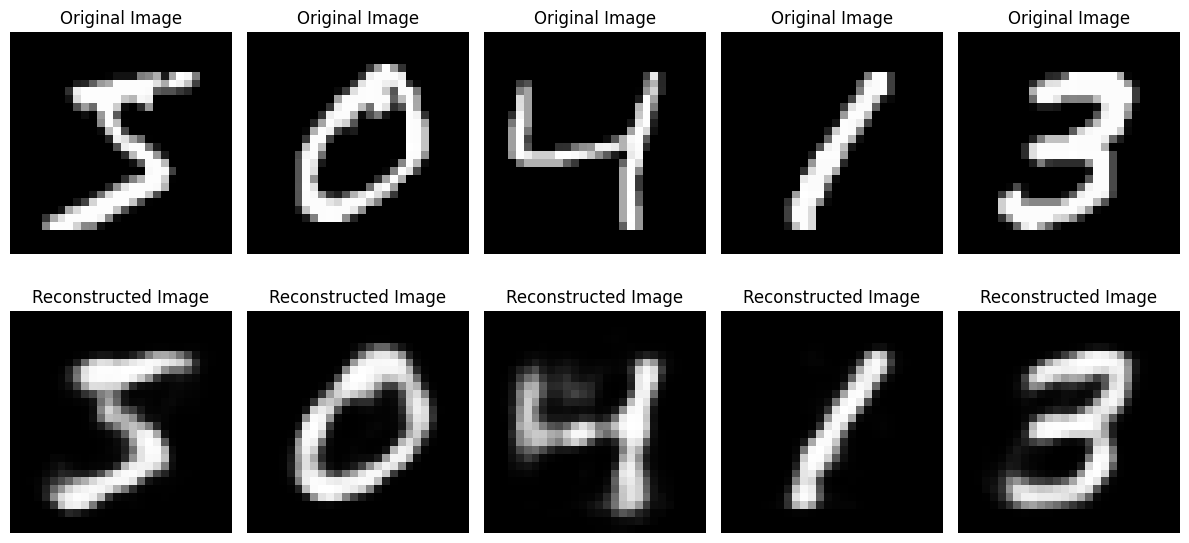

In [2]:
import matplotlib.pyplot as plt

sample_indices = [0, 1, 2, 3, 7] 

plt.figure(figsize=(12, 6))
num_samples = len(sample_indices)
for i, idx in enumerate(sample_indices, 1):

    plt.subplot(2, num_samples, i)
    plt.imshow(train_images[idx].reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i)
    reconstructed_data = rbm.sample_visible(rbm.sample_hidden(train_images[idx][None])[0])[0]
    plt.imshow(reconstructed_data.numpy().reshape(28, 28), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

plt.tight_layout()
plt.show()
